In [1]:
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rn


from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from PIL import ImageDraw

from time import time
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom
# from scipy.ndimage import imread


from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras import layers
from keras.preprocessing.image import save_img
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.models import Sequential,Input,Model,load_model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D,BatchNormalization,MaxPool2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

import pydot
from tensorflow.keras.losses import CategoricalCrossentropy

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn

In [2]:
# MODEL IMAGES PATHS
path_to_vgg16_model_image = "model_images/vgg16.png"
path_to_alexNet_model_image = "model_images/alexNet.png"

# MODEL WEIGHTS PATHS
# set always net path for weights
path_to_vgg16_model_weights = "./vgg16_weights/vgg16_model_weights"
path_to_alexNet_model_weights = "./alexNet_weights/alexNet_model_weights"

# CSV LOGS PATHS
path_to_vgg16_csvlog = "./csv_logs/vgg16"
path_to_alexNet_csvlog = "./csv_logs/alexNet"

# JSON MODEL PRESENTATION PATHS
vgg16_model_json_path = "./json_models/vgg16.json"
alexNet_model_json_path = "./json_models/alexNet.json"

# MODEL PATHS
path_to_vgg16_model = "./models/vgg16"
path_to_alexNet_model = "./models/alexNet"

# Number of epochs hyperparameter
num_of_epochs = 50

In [3]:
RANDOM_STATE = 1234

In [4]:
# PATH TO FOOD IMAGES
beans = 'images/BEANS'
cake = 'images/CAKE'
candy = 'images/CANDY'
cereal = 'images/CEREAL'
chips = 'images/CHIPS'
chocolate = 'images/CHOCOLATE'
coffee = 'images/COFFEE'
corn = 'images/CORN'
fish = 'images/FISH'
flour = 'images/FLOUR'
honey = 'images/HONEY'
jam = 'images/JAM'
juice = 'images/JUICE'
milk = 'images/MILK'
nuts = 'images/NUTS'
oil = 'images/OIL'
pasta = 'images/PASTA'
rice = 'images/RICE'
soda = 'images/SODA'
spices = 'images/SPICES'
sugar = 'images/SUGAR'
tea = 'images/TEA'
tomato_sauce = 'images/TOMATO_SAUCE'
vinegar = 'images/VINEGAR'
water = 'images/WATER'

X = []
Z = []
imgsize = 150

In [5]:
def training_data(label,data_dir):
    for img in tqdm(os.listdir(data_dir)):
        path = os.path.join(data_dir,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(imgsize,imgsize))
        
        X.append(np.array(img))
        Z.append(str(label))

In [6]:
def print_model(model, model_name):
    plot_model(model, to_file = model_name, show_shapes=True, show_layer_names=True)
    SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [7]:
# VGG16 arhitecture
def vgg16_model(img_rows,img_cols):
    base_model = VGG16(include_top=False,
                      input_shape = (img_rows,img_cols,3),
                      weights = 'imagenet',
                      )

    for layer in base_model.layers:
        layer.trainable = False

    for layer in base_model.layers:
        print(layer,layer.trainable)

    model = Sequential()
    model.add(base_model)
#     my layers
    model.add(GlobalAveragePooling2D())
#     model.add(Dropout(0.3))
    model.add(Dense(1000,activation='relu'))
    model.add(Dropout(0.35))
    model.add(Dense(25,activation='softmax'))
    model.summary()
    
    return model

In [8]:
# alexNet arhitecture
def alexNet_model(img_rows,img_cols):

    model = Sequential([
    Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(img_rows,img_cols,3)),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(25, activation='softmax')
                                  ])
    model.summary()
    
    return model

In [9]:
def plot_acc_loss(history, num_of_epochs):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(np.arange(0, num_of_epochs), history.history['loss'], label='train')
    plt.plot(np.arange(0, num_of_epochs), history.history['val_loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.plot(np.arange(0, num_of_epochs), history.history['accuracy'], label='train')
    plt.plot(np.arange(0, num_of_epochs), history.history['val_accuracy'], label='val')
    plt.legend(loc='best')

    plt.show()

In [10]:
def evaluate_model(model,x_test,y_test,classes_names,conf_matrix_name):
    score = model.evaluate(x_test, y_test, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    y_predicted = model.predict(x_test)
    y_predicted_classes = np.argmax(y_predicted, axis = 1)
    y_test_classes = np.argmax(y_test, axis = 1)
    
    conf_mat = confusion_matrix(y_test_classes, y_predicted_classes)
    
    df_cm = pd.DataFrame(conf_mat, index = [i for i in classes_names],
                  columns = [i for i in classes_names])
    plt.figure(figsize = (16,12))
    plt.title(conf_matrix_name)
    sn.heatmap(df_cm, annot=True)
    plt.savefig('./confusion_matrices/' + conf_matrix_name)
    
    report = classification_report(y_test_classes, y_predicted_classes)
    print(report)
    
    
    y_predicted_classes.shape, y_test_classes.shape

In [11]:
def write_model_as_json(model, path):
    model_json = model.to_json()
    with open(path,"w") as json_file:
        json_file.write(model_json)

In [12]:
# INITIAL CNN MODEL

# model = Sequential([
#     Input(shape=input_shape),
#     Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
#     MaxPooling2D(pool_size=(2, 2)),
#     Dropout(0.25),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(number_of_classes, activation='softmax')
# ])

# model.summary()
# display(SVG(model_to_dot(model, dpi=65).create(prog='dot', format='svg')))
# model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
# batch_size = 128
# epochs = 12
# history = model.fit(x_train, y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=1,
#                     validation_split=0.2)

In [13]:
def test_model():
    model = Sequential([
        Input(shape=(150,150,3)),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(25, activation='softmax')
    ])
    
    model.summary()
    return model

In [14]:
training_data('beans',beans)
training_data('cake',cake)
training_data('candy',candy)
training_data('cereal',cereal)
training_data('chips',chips)
training_data('chocolate',chocolate)
training_data('coffee',coffee)
training_data('corn',corn)
training_data('fish',fish)
training_data('flour',flour)
training_data('honey',honey)
training_data('jam',jam)
training_data('juice',juice)
training_data('milk',milk)
training_data('nuts',nuts)
training_data('oil',oil)
training_data('pasta',pasta)
training_data('rice',rice)
training_data('soda',soda)
training_data('spices',spices)
training_data('sugar',sugar)
training_data('tea',tea)
training_data('tomato sauce',tomato_sauce)
training_data('vinegar',vinegar)
training_data('water',water)

100%|██████████| 262/262 [00:00<00:00, 414.81it/s]


In [15]:
# shape of image
X[0].shape

(150, 150, 3)

In [16]:
# image data format
K.image_data_format()

'channels_last'

In [17]:
len(X),len(Z)

(4947, 4947)

In [18]:
label_encoder= LabelEncoder()
Y = label_encoder.fit_transform(Z)

In [19]:
Y

array([ 0,  0,  0, ..., 24, 24, 24], dtype=int64)

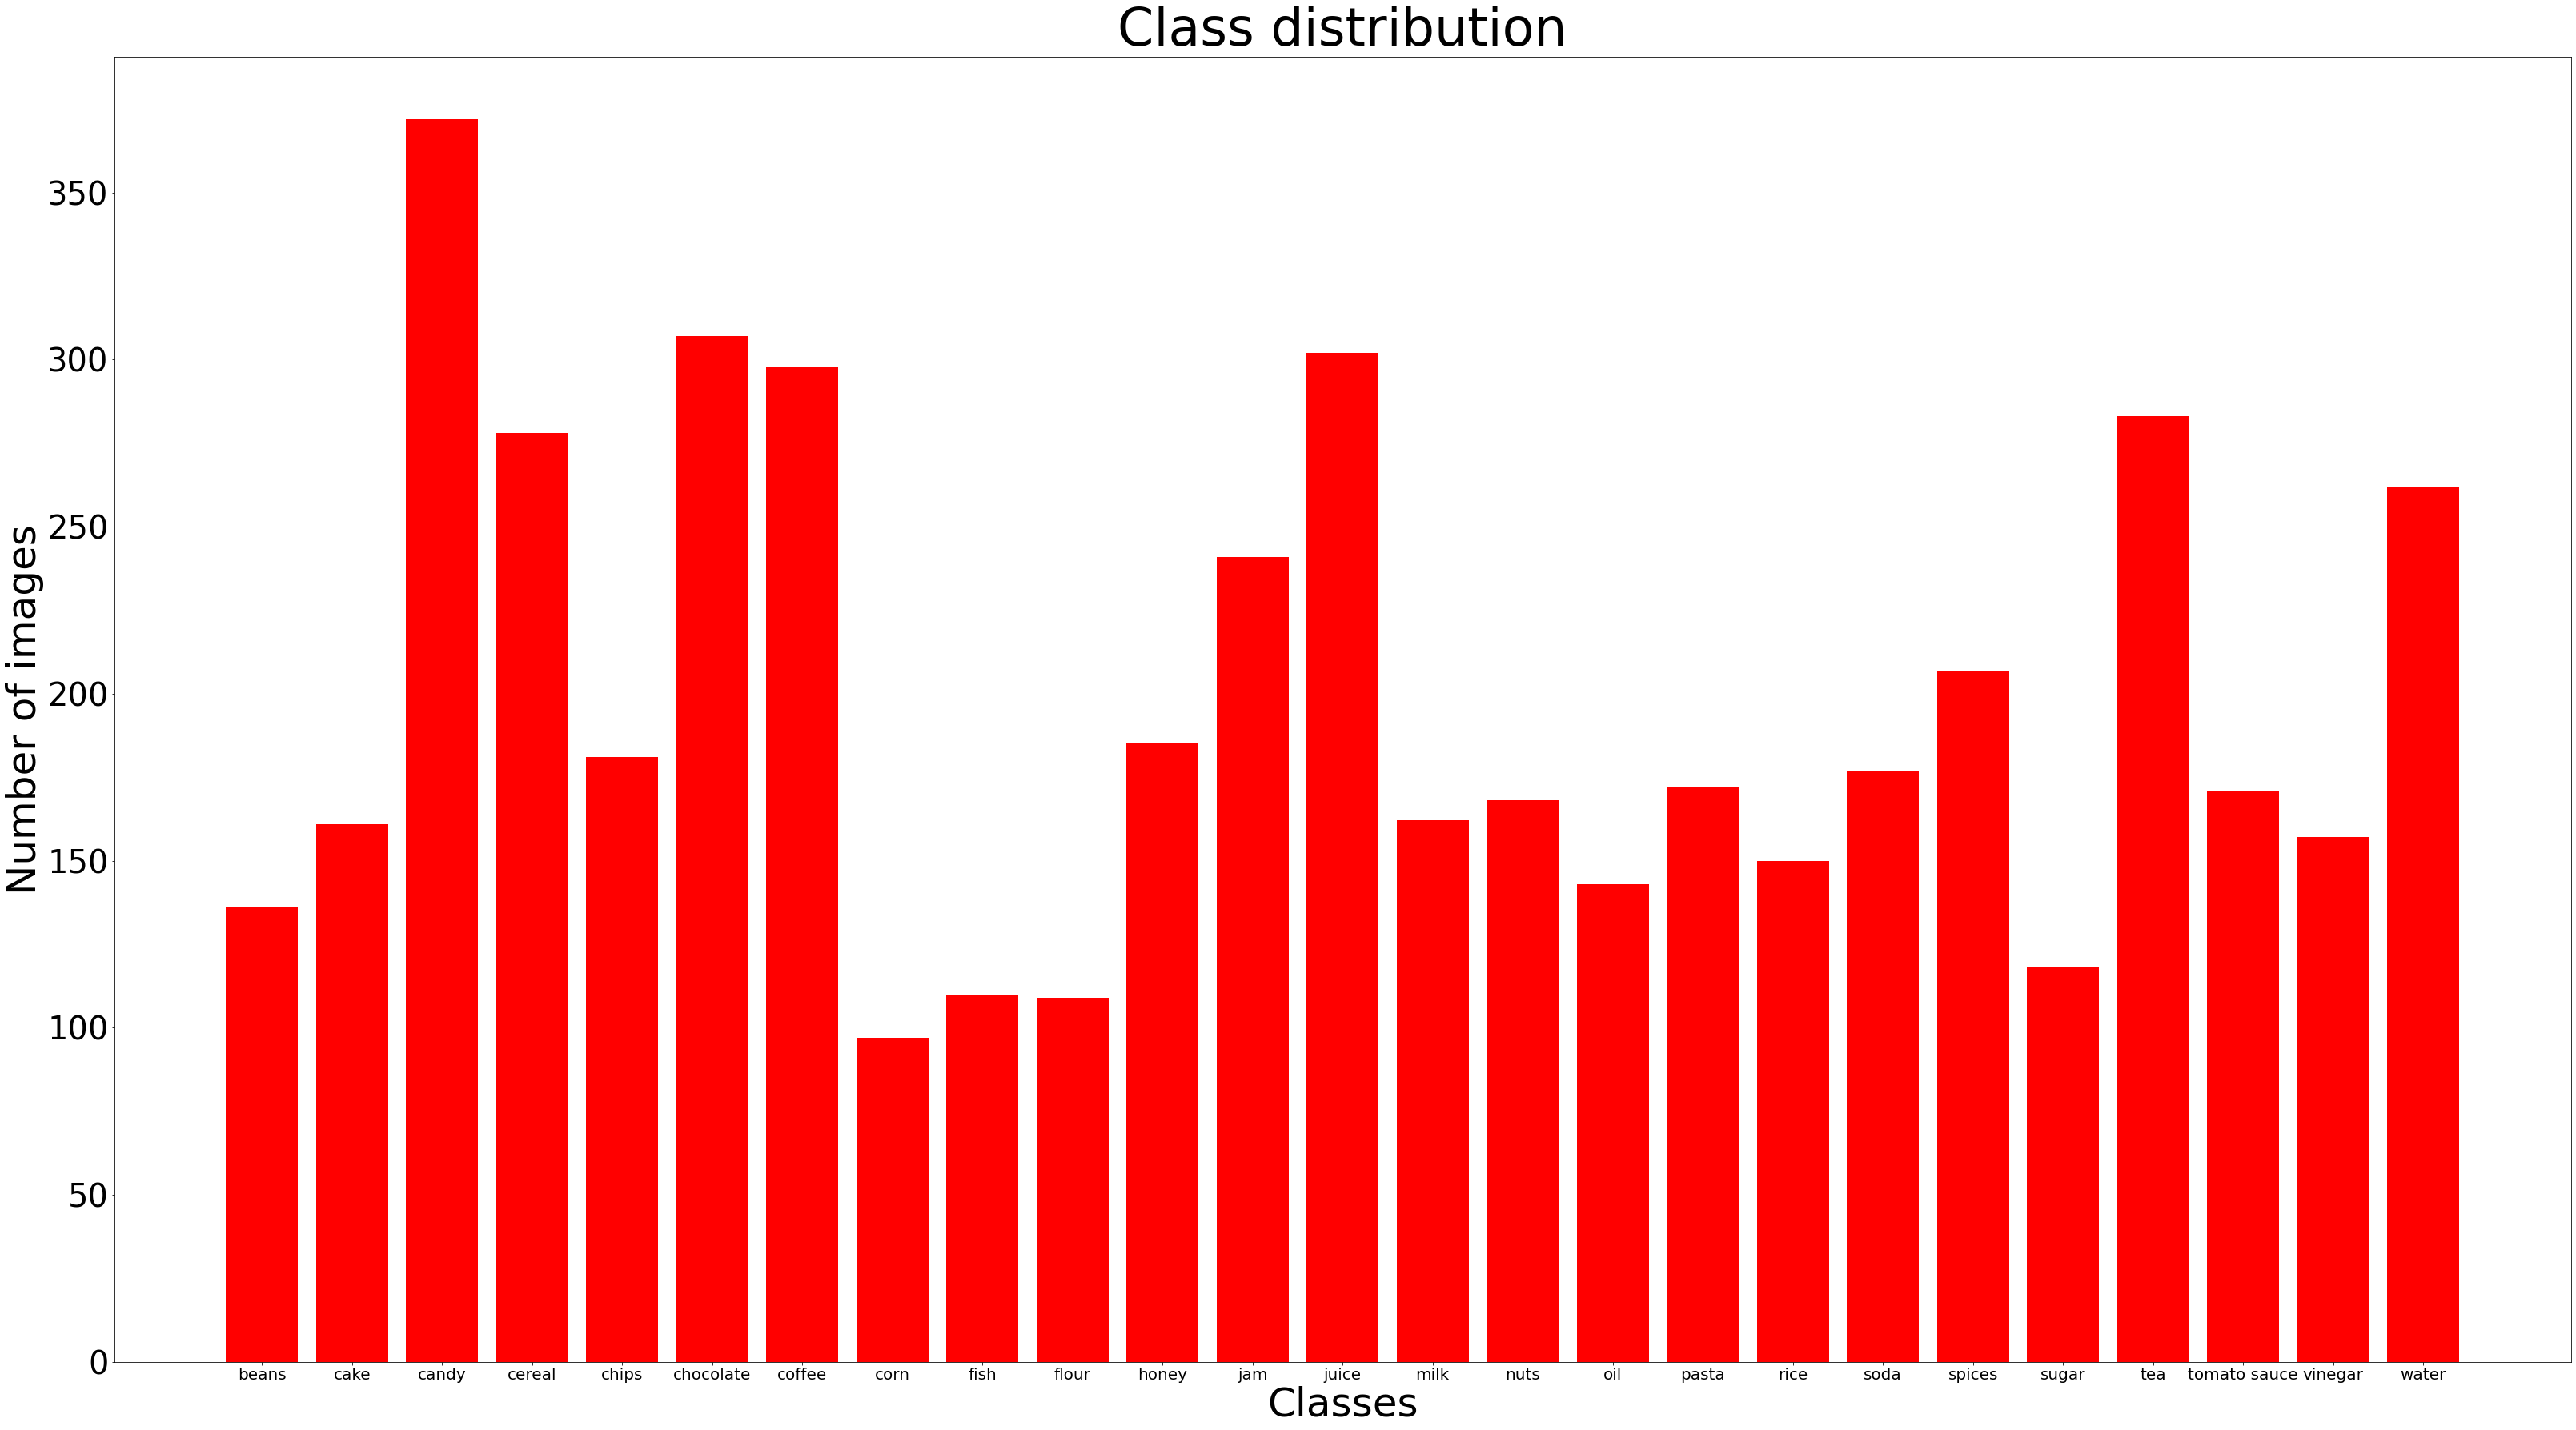

In [20]:
# bar diagram of class distribution
classes_names = ['beans','cake','candy','cereal','chips','chocolate','coffee','corn','fish','flour','honey',
                'jam','juice','milk','nuts','oil','pasta','rice','soda','spices','sugar','tea','tomato sauce','vinegar','water']
plt.figure(figsize=(55,30))
plt.title('Class distribution', fontsize=65)
plt.xlabel('Classes', fontsize=50)
plt.ylabel('Number of images', fontsize=50)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 40)
plt.bar(classes_names,np.bincount(Y), color = 'r')
plt.show()

In [21]:
Y = to_categorical(Y,25)

In [22]:
Y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [23]:
# data scaling
X = np.array(X)
X = X.astype('float32')
X=X/255

In [24]:
X.shape,Y.shape

((4947, 150, 150, 3), (4947, 25))

In [25]:
# train - test - val split
# x_train_val, x_test, y_train_val, y_test = train_test_split(X,Y,test_size=0.2,random_state=RANDOM_STATE,stratify=Y)
# x_train, x_val, y_train, y_val = train_test_split(x_train_val,y_train_val,test_size=0.2,random_state=RANDOM_STATE,stratify=y_train_val)
# x_train.shape,y_train.shape,x_val.shape,y_val.shape,x_test.shape,y_test.shape

# split only on x_train - y_train because we will use ImageDataGenerator on x_train for validation instances
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=RANDOM_STATE,stratify=Y)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((3462, 150, 150, 3), (1485, 150, 150, 3), (3462, 25), (1485, 25))

In [26]:
# CHECK IF X_TEST HAVE ALL CLASSES

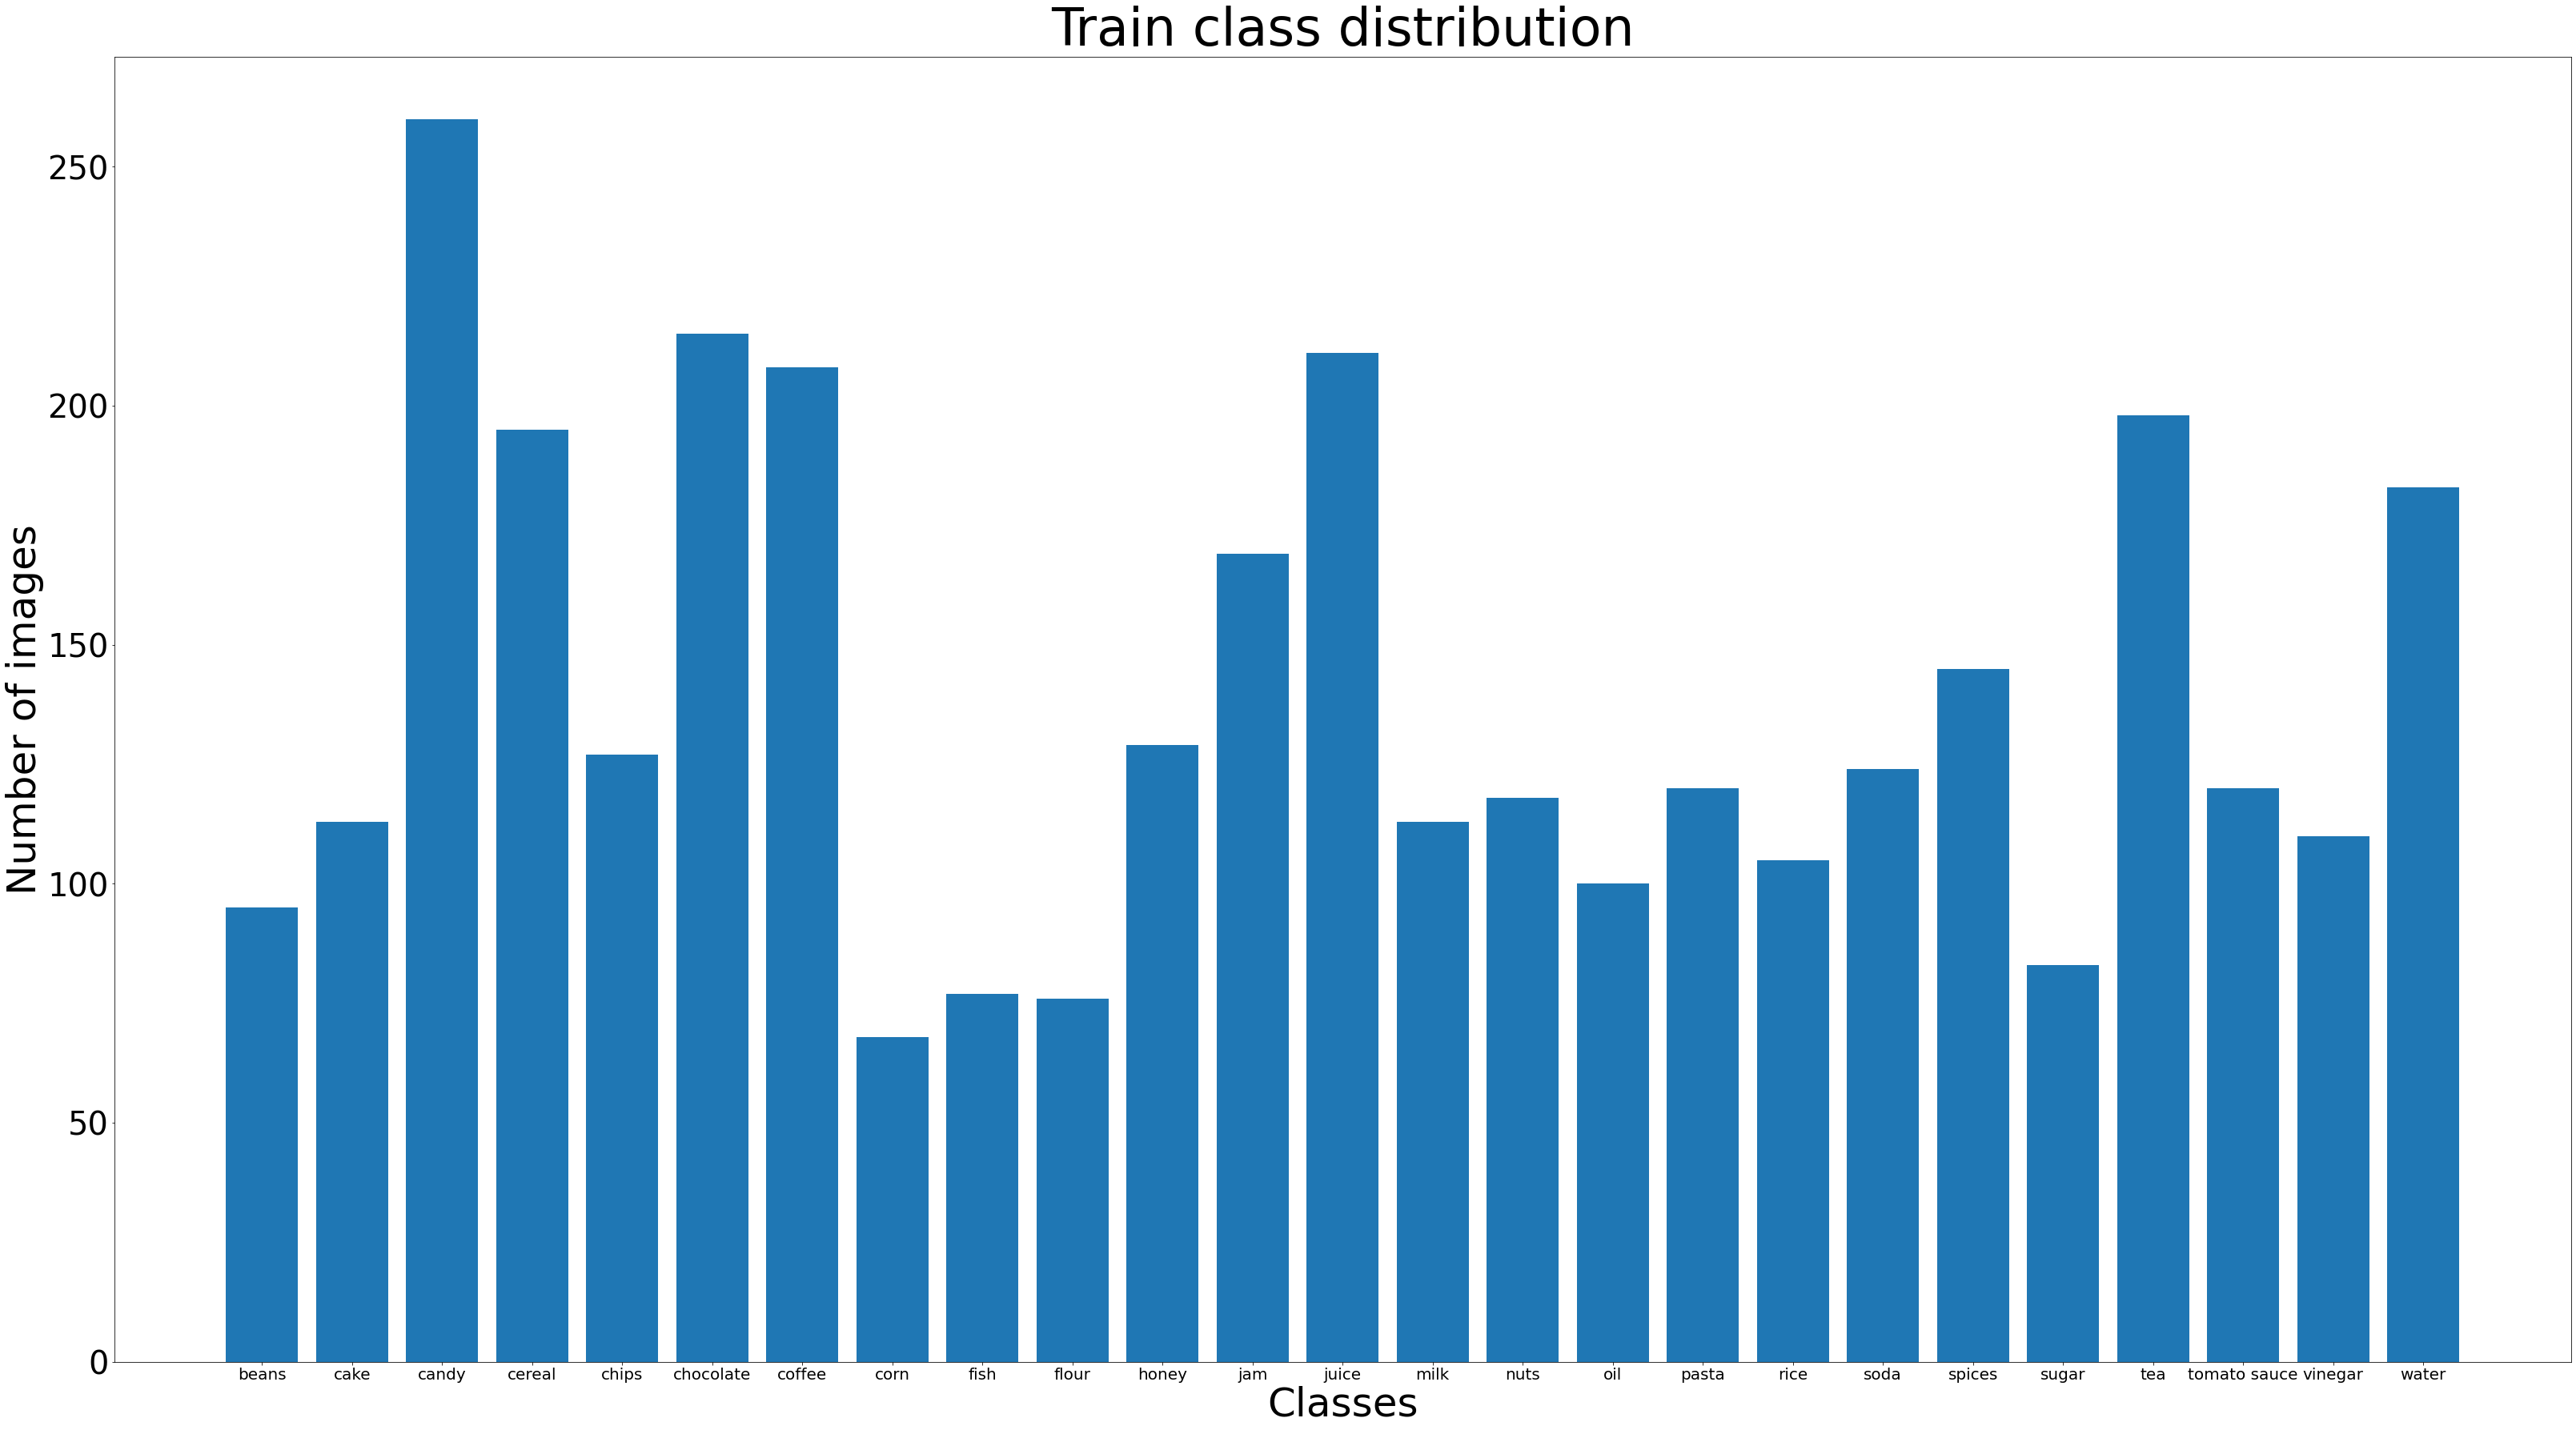

In [27]:
y_train_cls = np.argmax(y_train, axis = 1)
plt.figure(figsize=(55,30))
plt.title('Train class distribution', fontsize=65)
plt.xlabel('Classes', fontsize=50)
plt.ylabel('Number of images', fontsize=50)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 40)
plt.bar(classes_names,np.bincount(y_train_cls))
plt.show()

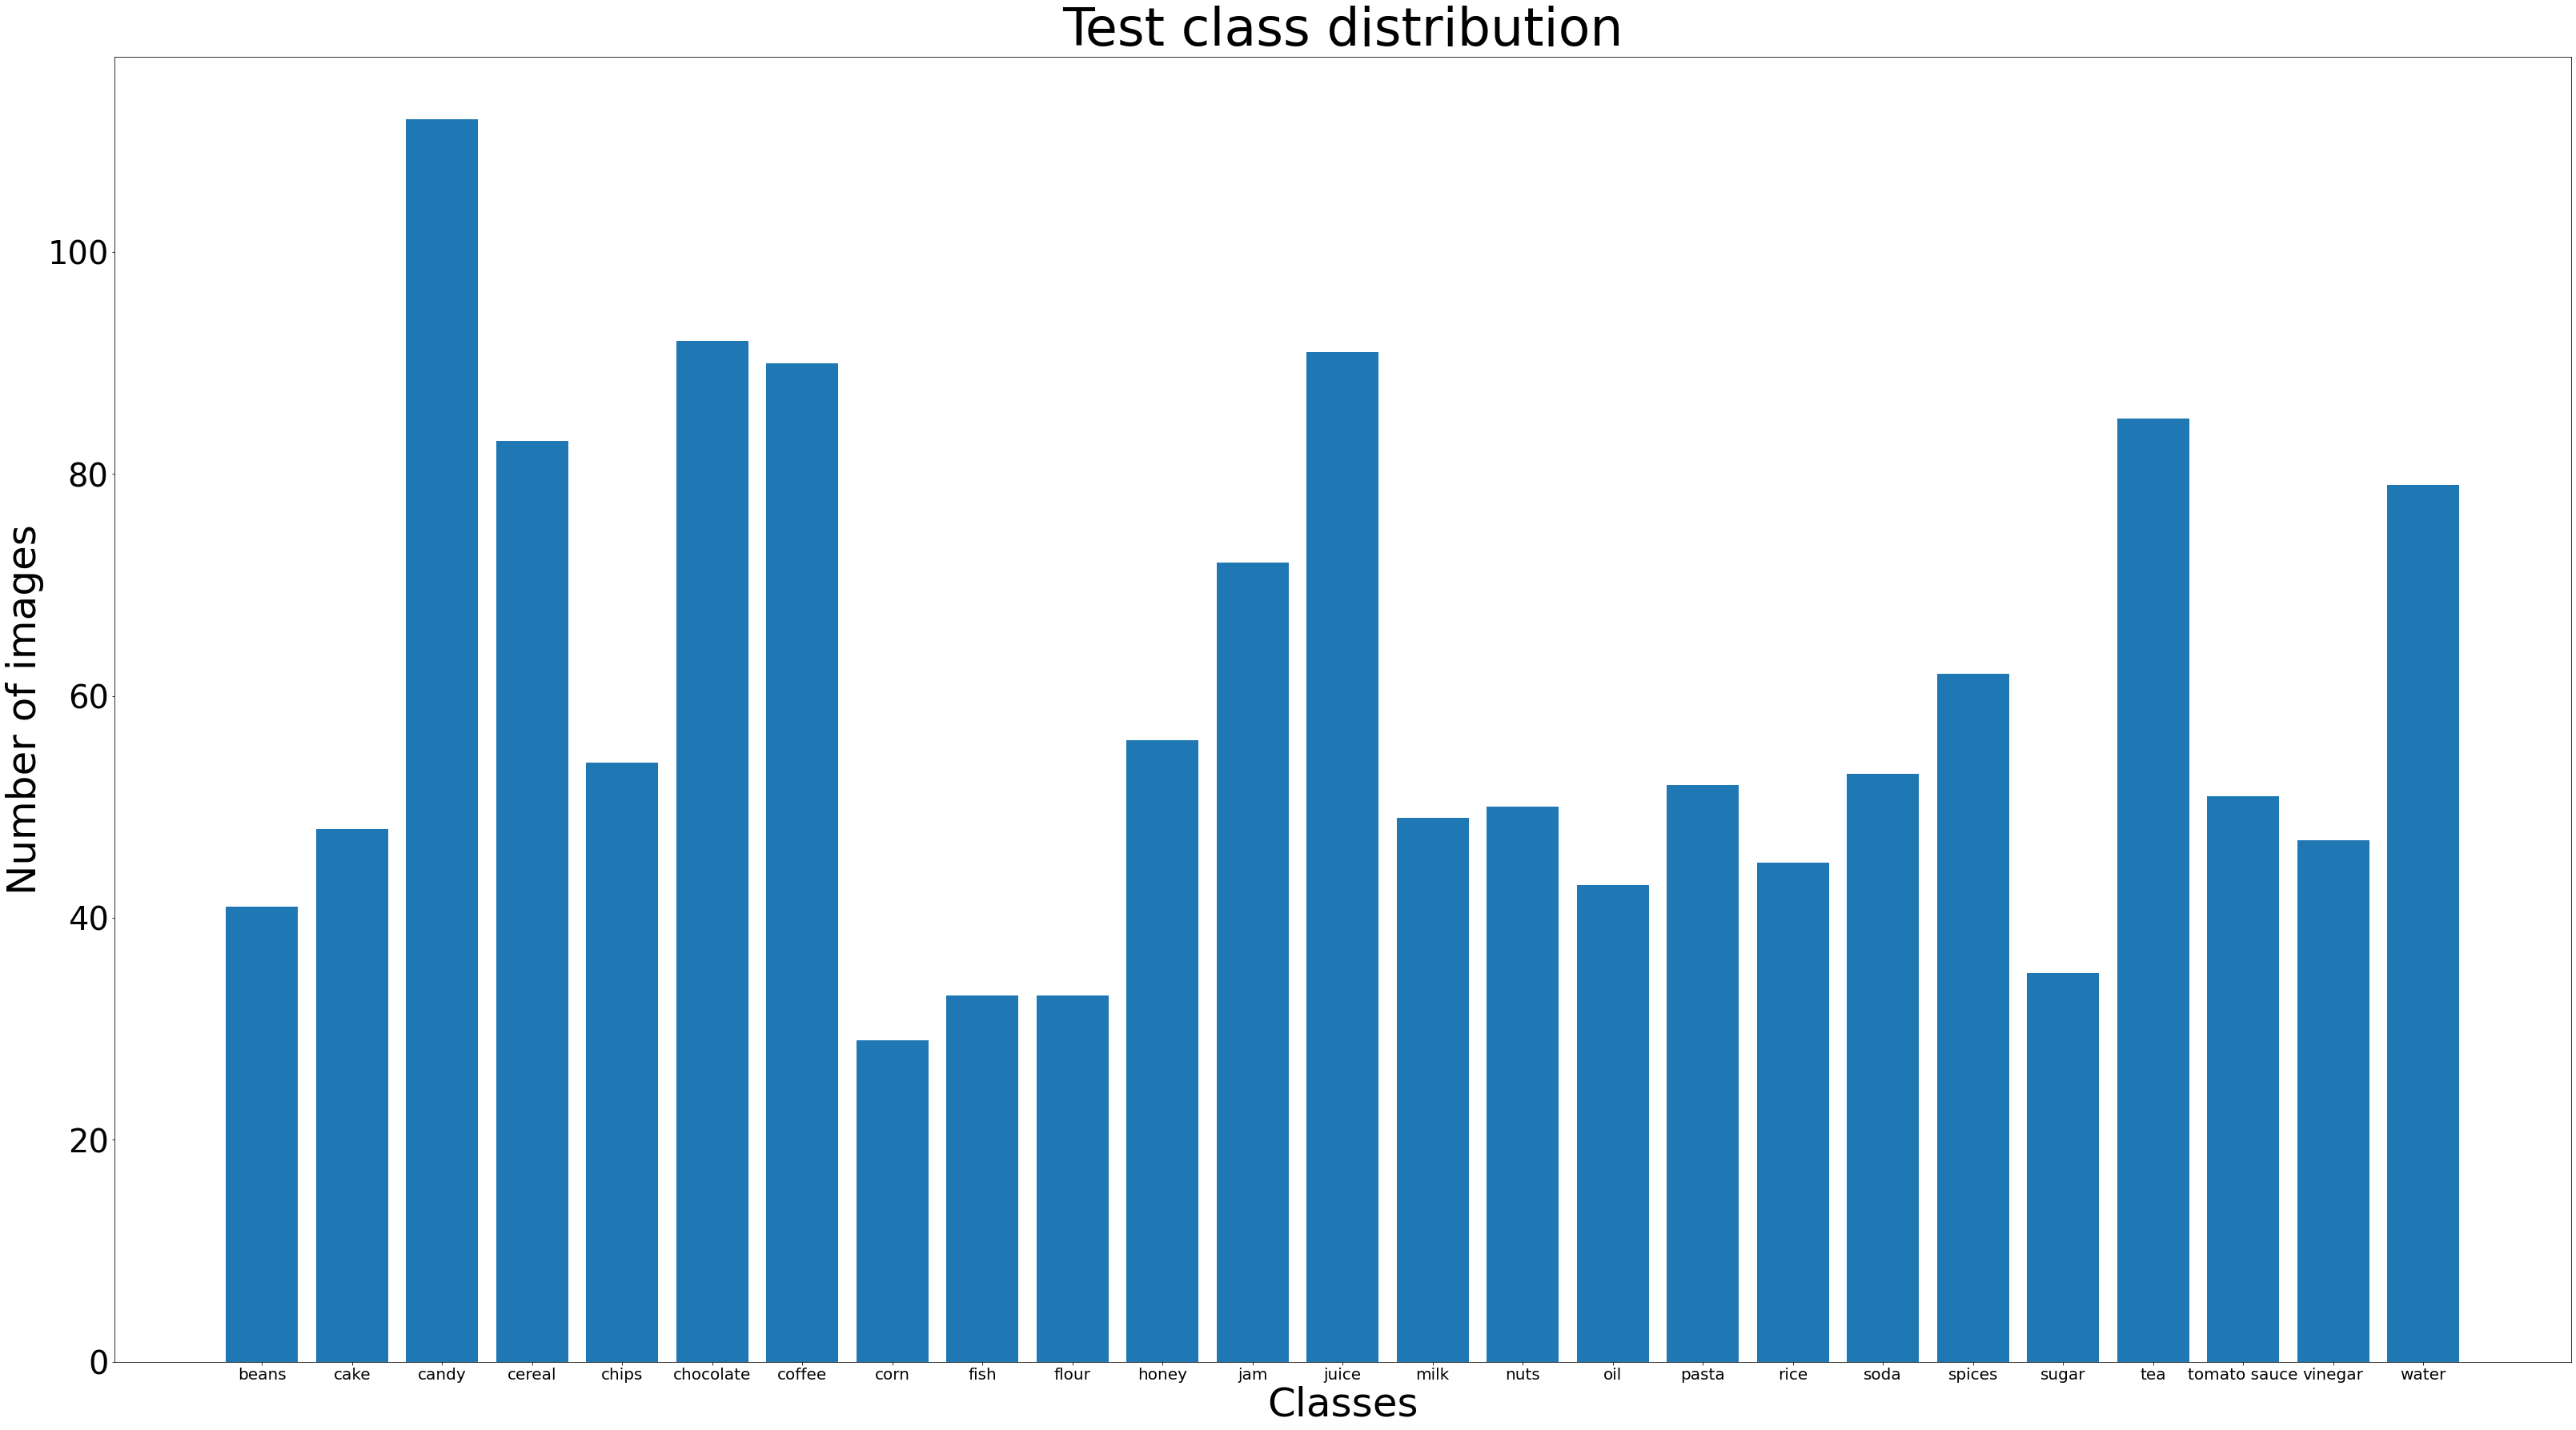

In [28]:
y_test_cls = np.argmax(y_test, axis = 1)
plt.figure(figsize=(55,30))
plt.title('Test class distribution', fontsize=65)
plt.xlabel('Classes', fontsize=50)
plt.ylabel('Number of images', fontsize=50)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 40)
plt.bar(classes_names,np.bincount(y_test_cls))
plt.show()

In [29]:
# image data generator
augs_gen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.2,  
        height_shift_range=0.2, 
        horizontal_flip=True,  
        vertical_flip=False,
        validation_split=0.3) 

augs_gen.fit(x_train)

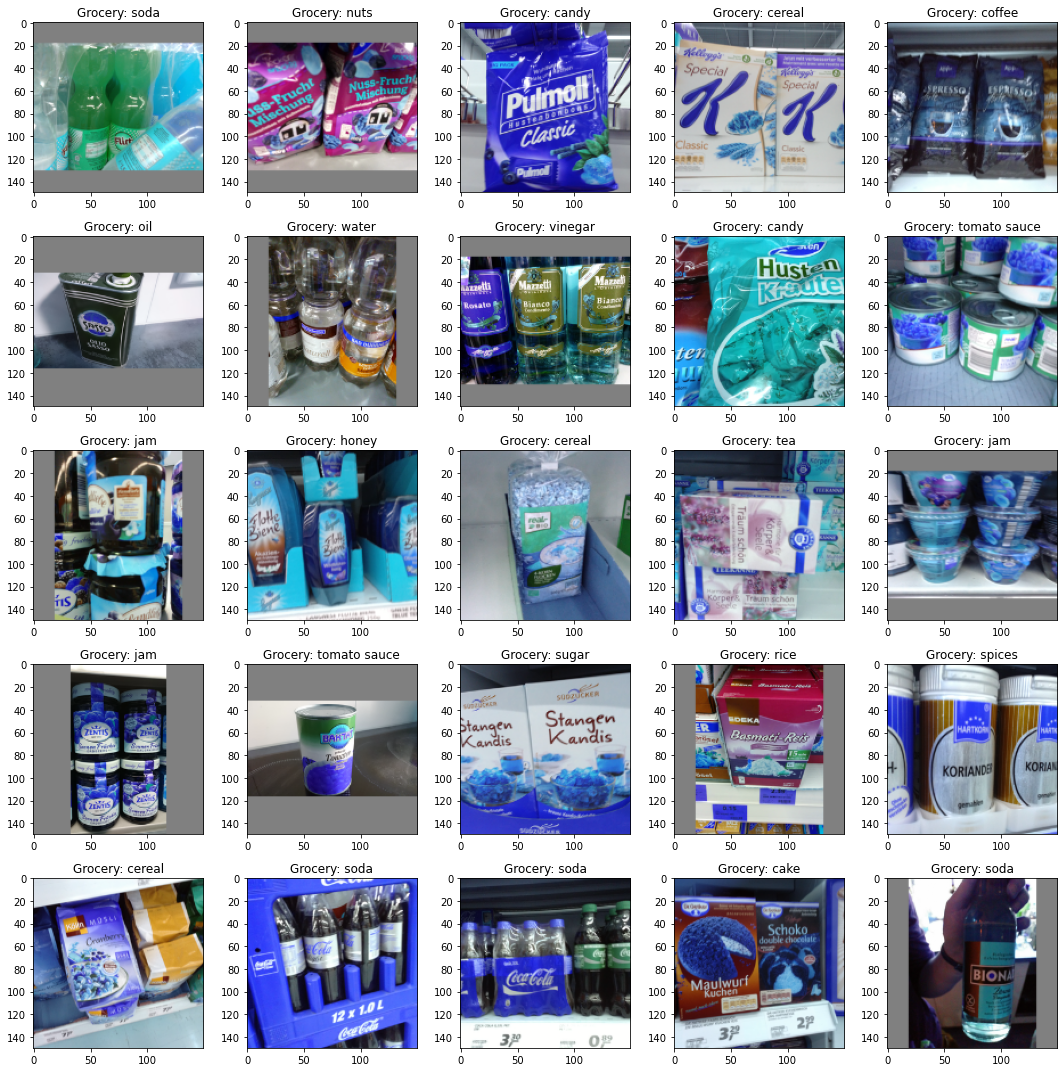

In [30]:
fig,ax=plt.subplots(5,5)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (5):
        k = rn.randint(0, len(Z))
        ax[i,j].imshow(X[k])
        ax[i,j].set_title('Grocery: '+ Z[k])
        
plt.tight_layout()

In [31]:
img_rows = imgsize
img_cols = imgsize
img_rows, img_cols

(150, 150)

In [32]:
# channels_last img format
input_shape = (img_rows, img_cols, 3)
number_of_classes = 25

In [33]:
# model = test_model()
model = alexNet_model(img_rows, img_cols)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 35, 35, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 35, 35, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 17, 17, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 17, 17, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 384)         8

In [34]:
print_model(model, path_to_alexNet_model_image)
# SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [35]:
checkpoint = ModelCheckpoint(
    filepath=path_to_alexNet_model_weights,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True
)

# TensorBoard provides the visualization
# tensorboard = TensorBoard(
#     log_dir = './vgg16logs',
#     histogram_freq=0,
#     batch_size=16,
#     write_graph=True,
#     write_grads=True,
#     write_images=False,
# )

csvlogger = CSVLogger(
    filename= path_to_alexNet_csvlog,
    separator = ",",
    append = False
)


# Reduce learning rate when a metric has stopped improving
# reduce = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.1,
#     patience=3,
#     verbose=1, 
#     mode='auto'
# )

callbacks = [checkpoint, csvlogger]

In [36]:
model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

history = model.fit(
                    augs_gen.flow(x_train, y_train, batch_size = 32,  subset='training'),
                    epochs = num_of_epochs,
                    verbose = 1,
                    validation_data  = augs_gen.flow(x_train, y_train, batch_size=8, subset='validation'),
                    callbacks=callbacks
                    )

Epoch 1/50
76/76 [==============================] - 90s 1s/step - loss: 5.4639 - accuracy: 0.0941 - val_loss: 3.5189 - val_accuracy: 0.0674
Epoch 2/50
76/76 [==============================] - 89s 1s/step - loss: 3.1839 - accuracy: 0.1366 - val_loss: 3.7662 - val_accuracy: 0.0443
Epoch 3/50
76/76 [==============================] - 85s 1s/step - loss: 3.1223 - accuracy: 0.1238 - val_loss: 3.1521 - val_accuracy: 0.1243
Epoch 4/50
76/76 [==============================] - 88s 1s/step - loss: 3.0698 - accuracy: 0.1382 - val_loss: 2.9402 - val_accuracy: 0.1435
Epoch 5/50
76/76 [==============================] - 87s 1s/step - loss: 2.9658 - accuracy: 0.1531 - val_loss: 3.6715 - val_accuracy: 0.0636
Epoch 6/50
76/76 [==============================] - 88s 1s/step - loss: 2.9803 - accuracy: 0.1535 - val_loss: 3.2160 - val_accuracy: 0.1118
Epoch 7/50
76/76 [==============================] - 91s 1s/step - loss: 2.9635 - accuracy: 0.1547 - val_loss: 3.0382 - val_accuracy: 0.1561
Epoch 8/50
76/76 [==

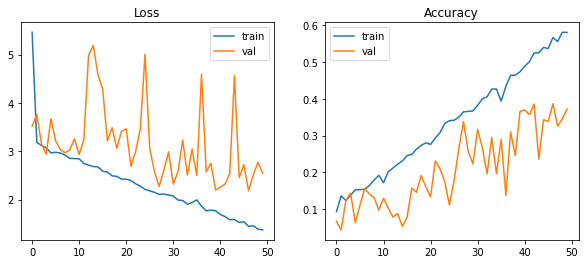

In [37]:
plot_acc_loss(history,num_of_epochs)

In [38]:
# MODEL EVALUATION

109/109 [==============================] - 25s 228ms/step - loss: 1.7092 - accuracy: 0.5292
Test loss: 1.7091854810714722
Test accuracy: 0.5291739106178284
              precision    recall  f1-score   support

           0       0.87      0.43      0.58        95
           1       0.55      0.48      0.51       113
           2       0.99      0.25      0.40       260
           3       0.57      0.23      0.32       195
           4       0.69      0.40      0.51       127
           5       0.65      0.46      0.54       215
           6       0.36      0.67      0.47       208
           7       0.58      0.59      0.58        68
           8       0.52      0.53      0.53        77
           9       0.32      0.12      0.17        76
          10       0.72      0.43      0.54       129
          11       0.75      0.78      0.76       169
          12       0.57      0.65      0.61       211
          13       0.60      0.62      0.61       113
          14       0.60      0.15

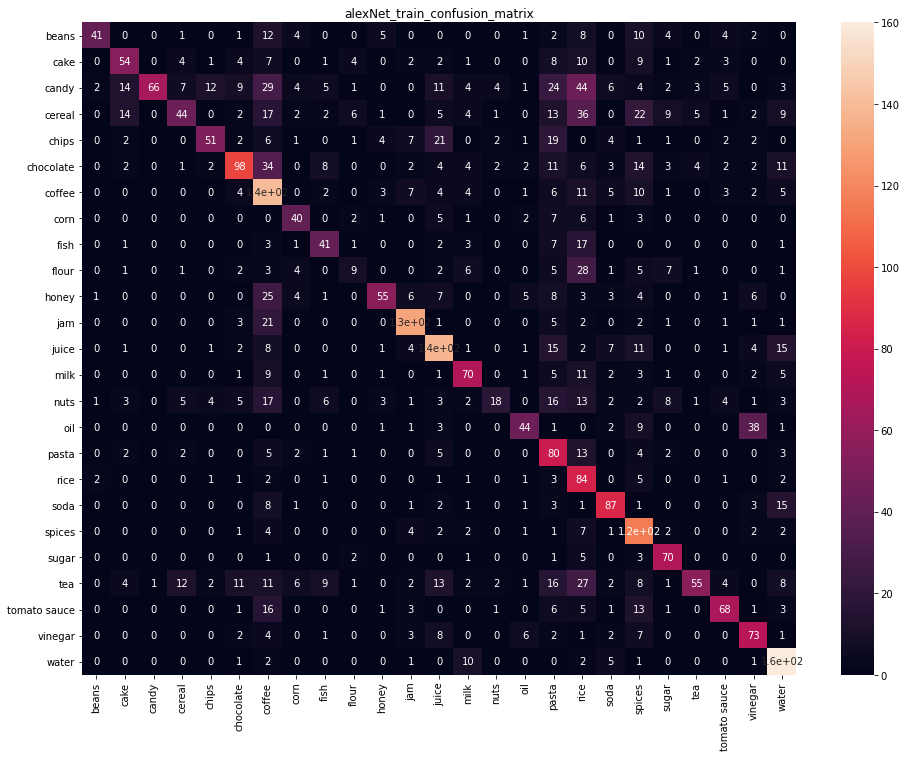

In [39]:
# TRAIN EVALUATION
evaluate_model(model,x_train,y_train,classes_names,"alexNet_train_confusion_matrix")

47/47 [==============================] - 14s 293ms/step - loss: 2.3914 - accuracy: 0.3879
Test loss: 2.3914246559143066
Test accuracy: 0.38787877559661865
              precision    recall  f1-score   support

           0       0.46      0.15      0.22        41
           1       0.36      0.29      0.32        48
           2       0.80      0.14      0.24       112
           3       0.12      0.05      0.07        83
           4       0.43      0.22      0.29        54
           5       0.51      0.34      0.41        92
           6       0.25      0.51      0.33        90
           7       0.46      0.38      0.42        29
           8       0.38      0.36      0.37        33
           9       0.29      0.12      0.17        33
          10       0.42      0.14      0.21        56
          11       0.75      0.68      0.72        72
          12       0.48      0.53      0.50        91
          13       0.40      0.51      0.45        49
          14       0.38      0.10 

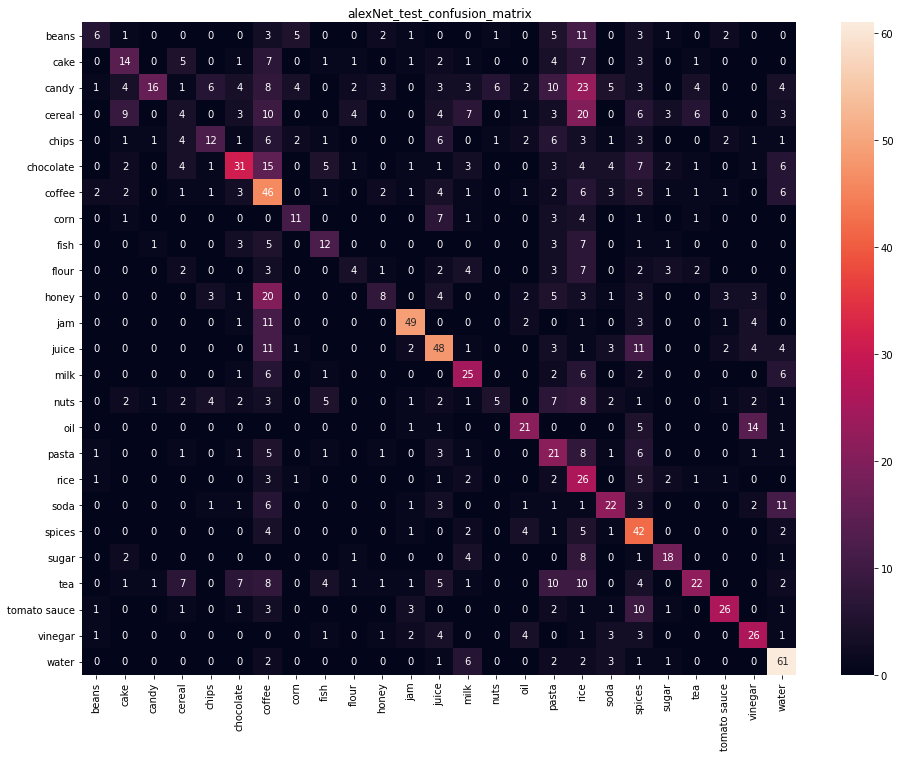

In [40]:
# TEST EVALUATION
evaluate_model(model,x_test,y_test,classes_names,"alexNet_test_confusion_matrix")

In [41]:
# take weights with max acc
# ret = model.load_weights(path_to_alexNet_model_weights)

In [42]:
# SAVING MODEL

In [43]:
write_model_as_json(model,alexNet_model_json_path)

In [44]:
model.save(path_to_alexNet_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./models/alexNet\assets


In [45]:
# model1 = load_model(path_to_alexNet_model)

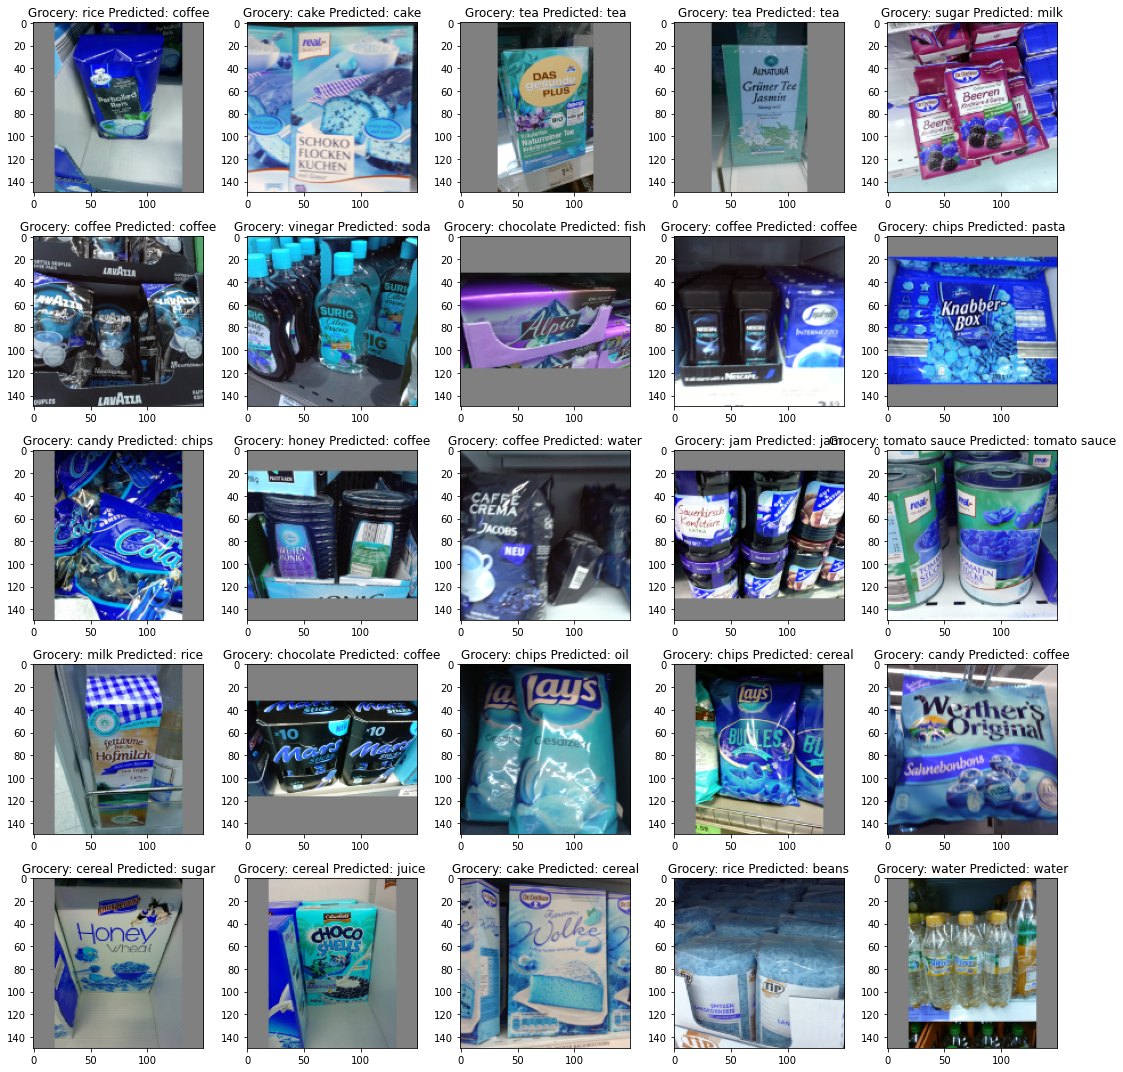

In [53]:
# evaluation on test
test_len = len(y_test)


fig,ax=plt.subplots(5,5)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range(5):
        k = rn.randint(0, test_len - 1)
        ax[i,j].imshow(x_test[k])
        ax[i,j].set_title('Grocery: '+ classes_names[np.argmax(y_test[k])] + " Predicted: " + classes_names[np.argmax(model.predict(x_test[k:k+1]))])
plt.tight_layout()  